# Exercise 6 - Convolutional Autoencoder

In this exercise we will construct a convolutional autoencoder for the sample of the CIFAR-10 dataset.

Import pickle, numpy, matplotlib as well as the *Model* class from **keras.models** and *Input* and *Conv2D*, *MaxPooling2D* and *UpSampling2D* from **keras.layers**.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

Using TensorFlow backend.


Load the data

In [2]:
with open('data_batch_1', 'rb') as f:
    dat = pickle.load(f, encoding='bytes')

As this is an unsupervised learning method, we are only interested in the image data.  Load the image data as per the previous exercise.

In [3]:
images = np.zeros((10000, 32, 32, 3), dtype='uint8')

for idx, img in enumerate(dat[b'data']):
    images[idx, :, :, 0] = img[:1024].reshape((32, 32)) # Red
    images[idx, :, :, 1] = img[1024:2048].reshape((32, 32)) # Green
    images[idx, :, :, 2] = img[2048:].reshape((32, 32)) # Blue

As we are using a convolutional network we can use the images with only rescaling.

In [4]:
images = images / 255.

Define the convolutional autoencoder model.  We will use the same shape input as an image.

In [5]:
input_layer = Input(shape=(32, 32, 3,))

Add a convolutional stage, with 32 layers or filters, a 3 x 3 weight matrix, a ReLU activation function and using **same** padding which means the output has the same length as the input image.

In [6]:
hidden_encoding = Conv2D(
    32, # Number of layers or filters in the weight matrix
    (3, 3), # Shape of the weight matrix
    activation='relu',
    padding='same', # How to apply the weights to the images
)(input_layer)

Instructions for updating:
Colocations handled automatically by placer.


Add a max pooling layer to the encoder with a 2 x 2 kernel.  Max Pooling looks at all the values in an image, scanning through with a 2 x 2 matrix.  The maximum value in each 2 x 2 area is returned, thus reducing the size of the encoded layer by a half.

In [7]:
encoded = MaxPooling2D((2, 2))(hidden_encoding)

Add a decoding convolutional layer

In [8]:
hidden_decoding = Conv2D(
    32, # Number of layers or filters in the weight matrix
    (3, 3), # Shape of the weight matrix
    activation='relu',
    padding='same', # How to apply the weights to the images
)(encoded)

Now we need to return the image to its original size, for this we will upsample by the same size as Max Pooling.

In [9]:
upsample_decoding = UpSampling2D((2, 2))(hidden_decoding)

Add the final convolutional stage, using 3 layers for the RGB channels of the images.

In [10]:
decoded = Conv2D(
    3, # Number of layers or filters in the weight matrix
    (3, 3), # Shape of the weight matrix
    activation='sigmoid',
    padding='same', # How to apply the weights to the images
)(upsample_decoding)

Construct the model by passing the first and last layers of the network to the Model class.

In [11]:
autoencoder = Model(input_layer, decoded)

Display the structure of the model

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 3)         867       
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________


Compile the autoencoder using a binary cross entropy loss function and adadelta gradient descent.

In [13]:
autoencoder.compile(loss='binary_crossentropy',
              optimizer='adadelta')

Now let's fit the model, again we pass the images as the training data and as the desired output.  Train for 20 epochs as convolutional networks take a lot longer to compute.

In [14]:
autoencoder.fit(images, images, epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
10000/10000 [==============================] - 21s 2ms/step - loss: 0.5934
Epoch 2/20
10000/10000 [==============================] - 21s 2ms/step - loss: 0.5687
Epoch 3/20
10000/10000 [==============================] - 22s 2ms/step - loss: 0.5633
Epoch 4/20
10000/10000 [==============================] - 21s 2ms/step - loss: 0.5602
Epoch 5/20
10000/10000 [==============================] - 21s 2ms/step - loss: 0.5590: 0s - loss: 0
Epoch 6/20
10000/10000 [==============================] - 21s 2ms/step - loss: 0.5581
Epoch 7/20
10000/10000 [==============================] - 21s 2ms/step - loss: 0.5578
Epoch 8/20
10000/10000 [==============================] - 21s 2ms/step - loss: 0.5572
Epoch 9/20
10000/10000 [==============================] - 21s 2ms/step - loss: 0.5566
Epoch 10/20
10000/10000 [==============================] - 21s 2ms/step - loss: 0.5557
Epoch 11/20
10000/10000 [==============================] - 21s 2ms/step - los

Calculate and store the output of the encoding stage for the first 5 samples.

In [23]:
encoder_output = Model(input_layer, encoded).predict(images[:5])

Each encoded image has a shape of 16 x 16 x 32 due to the number of filters selected for the convolutional stage.  As such we cannot visualise them without modification.  We will reshape them to be 256 x 32 in size for visualisation.

In [24]:
encoder_output = encoder_output.reshape((-1, 256, 32))

Get the output of the decoder for the 5 images

In [25]:
decoder_output = autoencoder.predict(images[:5])

Plot the original image, the mean encoder output and the decoder.

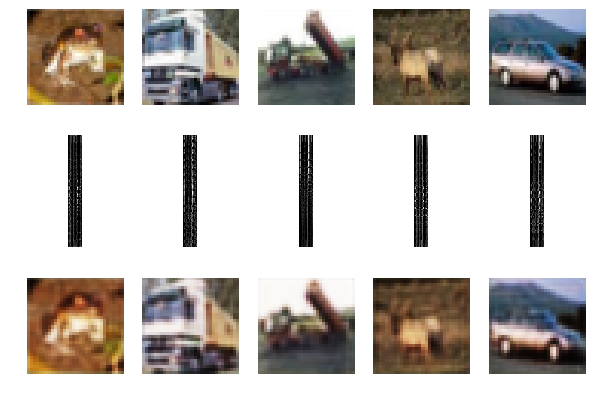

In [27]:
plt.figure(figsize=(10, 7))
for i in range(5):
    # Plot original images
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    
    # Plot encoder output
    plt.subplot(3, 5, i + 6)
    plt.imshow(encoder_output[i], cmap='gray')
    plt.axis('off')   
    
    # Plot decoder output
    plt.subplot(3, 5, i + 11)
    plt.imshow(decoder_output[i])
    plt.axis('off')        